In [11]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import matplotlib.ticker as mticker
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt


jason = pd.read_csv("manual/annotations_jason.csv", sep=";")
franek = pd.read_csv("manual/annotations_franek.csv", sep=";")

albert = pd.read_csv("manual/annotations_albert.csv", sep=";")
jonathan = pd.read_csv("manual/annotations_jonathan.csv", sep=";") 
data = pd.read_csv("../data/data_export.csv", sep=",")

In [12]:
albert['annotation_id'] = albert.index + 1

In [13]:
data['relevance_score'] = data['relevance_score'].astype(int)

In [14]:
print(f"Number of rows in data: {data.shape[0]}")

Number of rows in data: 15033


In [15]:
# Merge for Jason & Franek
jf = pd.merge(jason[['annotation_id','category']], 
              franek[['annotation_id','category']], 
              on='annotation_id', suffixes=('_jason','_franek'))
kappa_jason_franek = cohen_kappa_score(jf['category_jason'], jf['category_franek'])

# Merge for Albert & Jonathan
aj = pd.merge(albert[['annotation_id','category']], 
              jonathan[['annotation_id','category']], 
              on='annotation_id', suffixes=('_albert','_jonathan'))
kappa_albert_jonathan = cohen_kappa_score(aj['category_albert'], aj['category_jonathan'])

print("Kappa (Jason vs Franek):", kappa_jason_franek)
print("Kappa (Albert vs Jonathan):", kappa_albert_jonathan)
print("Mean Kappa:", (kappa_jason_franek + kappa_albert_jonathan) / 2)

Kappa (Jason vs Franek): 0.8904109589041096
Kappa (Albert vs Jonathan): 0.798590130916415
Mean Kappa: 0.8445005449102623


In [16]:
# Merge all four annotators by annotation_id
df_all = pd.concat([
    pd.merge(
        jason[['annotation_id','category']].rename(columns={'category':'cat_jason'}),
        franek[['annotation_id','category']].rename(columns={'category':'cat_franek'}),
        on='annotation_id'
    ),
    pd.merge(
        albert[['annotation_id','category']].rename(columns={'category':'cat_albert'}),
        jonathan[['annotation_id','category']].rename(columns={'category':'cat_jonathan'}),
        on='annotation_id'
    )
], ignore_index=True)

# Collect all possible categories from Jason, Franek, Albert, and Jonathan
all_possible_categories = sorted(set(df_all['cat_jason'].dropna()) 
                                 | set(df_all['cat_franek'].dropna())
                                 | set(df_all['cat_albert'].dropna())
                                 | set(df_all['cat_jonathan'].dropna()))

def min_max_cats(row):
    """
    For each row, create columns that show whether each category is chosen 
    as min or max by (jason, franek) and (albert, jonathan).
    """
    # Prepare a result dictionary initialized with zeros
    result = {}
    # We create two sets of columns: one for jason+franek and one for albert+jonathan
    for cat in all_possible_categories:
        result[f'{cat}_min'] = 0
        result[f'{cat}_max'] = 0


    # Pair 1: Jason + Franek
    jason_cat = row['cat_jason']
    franek_cat = row['cat_franek']
    if jason_cat == franek_cat:
        result[f'{jason_cat}_min'] = 1
        result[f'{jason_cat}_max'] = 1
    else:
        pair_jf = sorted([jason_cat, franek_cat])
        cat_min_jf, cat_max_jf = pair_jf[0], pair_jf[1]
        result[f'{cat_min_jf}_min'] = 0
        result[f'{cat_max_jf}_max'] = 1

    # Pair 2: Albert + Jonathan
    albert_cat = row['cat_albert']
    jonathan_cat = row['cat_jonathan']
    if albert_cat == jonathan_cat:
        result[f'{albert_cat}_min'] = 1
        result[f'{albert_cat}_max'] = 1
    else:
        pair_aj = sorted([albert_cat, jonathan_cat])
        cat_min_aj, cat_max_aj = pair_aj[0], pair_aj[1]
        result[f'{cat_min_aj}_min'] = 0
        result[f'{cat_max_aj}_max'] = 1

    return pd.Series(result)

# Apply the function to each row and join the results
df_minmax = df_all.apply(min_max_cats, axis=1)
df_all = df_all.join(df_minmax)


# Append predicted
combined_predicted = data
predicted_distribution = combined_predicted['predicted_category'].value_counts()

In [17]:
print(f"Number of rows in data: {combined_predicted.shape[0]}")

Number of rows in data: 15033


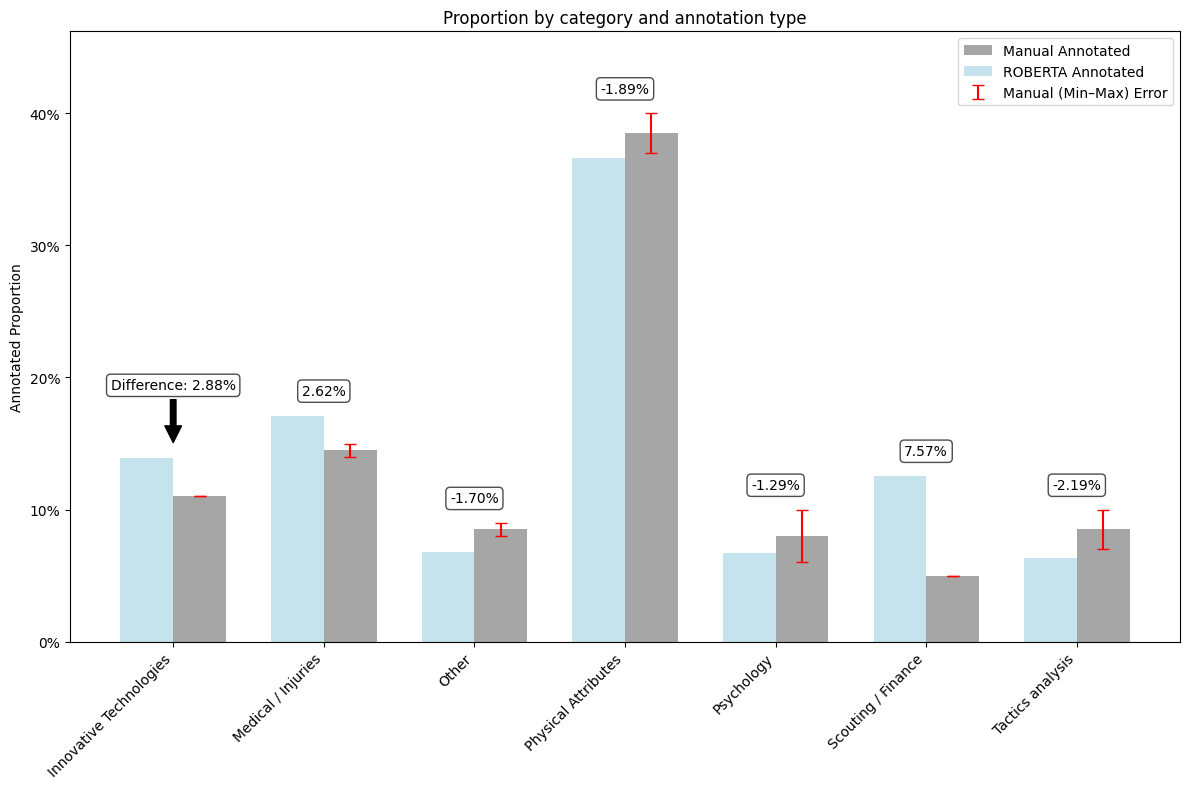

In [18]:
pred_counts = predicted_distribution
n_pred = pred_counts.sum()
pred_props = pred_counts / n_pred
all_cats = sorted(set(pred_props.index) | set(all_possible_categories))
pred_vals = [pred_props.get(cat, 0) for cat in all_cats]

manual_min_vals = []
manual_max_vals = []
differences = []

cat_min_sums = {}
cat_max_sums = {}
for cat in all_possible_categories:
    # Sum all the _min columns for this category
    min_col = [col for col in df_all.columns if col.endswith(f'{cat}_min')]
    # Sum all the _max columns for this category
    max_col = [col for col in df_all.columns if col.endswith(f'{cat}_max')]
    # Sum across those columns
    cat_min_sums[cat] = df_all[min_col].sum().sum()
    cat_max_sums[cat] = df_all[max_col].sum().sum()

for cat in all_cats:
    min_prop = cat_min_sums.get(cat, 0)/100
    max_prop = cat_max_sums.get(cat, 0)/100
    manual_min_vals.append(min_prop)
    manual_max_vals.append(max_prop)
    differences.append(pred_props.get(cat, 0) - (min_prop + max_prop) / 2)

x = np.arange(len(all_cats))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

manual_mid_vals = [(mn + mx) / 2 for mn, mx in zip(manual_min_vals, manual_max_vals)]
errors = [(mx - mn) / 2 for mn, mx in zip(manual_min_vals, manual_max_vals)]

rects1 = ax.bar(x + width/2, manual_mid_vals, width,
                label='Manual Annotated', color='grey', alpha=0.7)
rects2 = ax.bar(x - width/2, pred_vals, width, label='ROBERTA Annotated', color='lightblue', alpha=0.7)

ax.errorbar(x + width/2, manual_mid_vals, yerr=errors, fmt='none',
            ecolor='red', capsize=4, label='Manual (Min–Max) Error')

ax.set_ylabel('Annotated Proportion')
formatter = mticker.FuncFormatter(lambda y, _: f'{y * 100:.0f}%')
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Proportion by category and annotation type')
ax.set_xticks(x)
ax.set_xticklabels(all_cats, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)

for i, diff in enumerate(differences):
    diff_percent = diff * 100
    if i == 0:  
        ax.annotate(
            f'Difference: {diff_percent:.2f}%',
            xy=(x[i], max(pred_vals[i], manual_max_vals[i]) + 0.01),
            xytext=(x[i], max(pred_vals[i], manual_max_vals[i]) + 0.05),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center',
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.7)
        )
    else:
        ax.annotate(
            f'{diff_percent:.2f}%',
            xy=(x[i], max(pred_vals[i], manual_max_vals[i]) + 0.01),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords='offset points',
            ha='center',
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.7)
        )

fig.tight_layout()
plt.tight_layout()
plt.savefig(f"kappa.jpg", dpi=400)
plt.show()

In [19]:
# Create a table using pandas
data = {
    'Category': all_cats,
    'Predicted': [f"{val:.2%}" for val in pred_vals],
    'Manual Mid': [f"{val:.2%}" for val in manual_mid_vals],
    'Difference': [f"{val*100:.2f}%" for val in differences]
}
df = pd.DataFrame(data)
display(df)


,Category,Predicted,Manual Mid,Difference
0,Innovative Technologies,13.88%,11.00%,2.88%
1,Medical / Injuries,17.12%,14.50%,2.62%
2,Other,6.80%,8.50%,-1.70%
3,Physical Attributes,36.61%,38.50%,-1.89%
4,Psychology,6.71%,8.00%,-1.29%
5,Scouting / Finance,12.57%,5.00%,7.57%
6,Tactics analysis,6.31%,8.50%,-2.19%
